In [ ]:
%cd /content/drive/MyDrive/NMA_NeuroAI

/content/drive/MyDrive/NMA_NeuroAI


In [ ]:
from numba import jit
import numpy as np

In [ ]:
@jit(nopython=True, fastmath=True)
def make_sphere_array(radius):
    arr = np.full((2*radius+1,2*radius+1,2*radius+1), False)
    x0, y0, z0 = int(arr.shape[0]/2),int(arr.shape[1]/2),int(arr.shape[2]/2)
    for x in range(x0-radius, x0+radius+1):
        for y in range(y0-radius, y0+radius+1):
                for z in range(z0-radius, z0+radius+1):
                    deb = np.linalg.norm(np.array([x0-x, y0-y, z0-z], dtype=np.float32))
                    arr[x,y,z] = True if deb <= radius else False
    return arr


def search_light_analysis(data, radius, search_area=None, post_func=None):
    search_area = data if search_area is None else search_area
    post_func = (lambda x:x) if post_func is None else post_func
    sphere_mask = make_sphere_array(radius)
    for x0 in range(radius, data.shape[0]-radius):
        for y0 in range(radius, data.shape[1]-radius):
            for z0 in range(radius, data.shape[2]-radius):
                if search_area[x0,y0,z0]:
                    target_area = data[x0-radius:x0+radius+1,y0-radius:y0+radius+1,z0-radius:z0+radius+1].copy()
                    available_mask = (target_area.sum(axis=3)!=0) & sphere_mask
                    if np.any(available_mask):
                        values = target_area[available_mask]
                        result = post_func(values)
                        yield result, (x0,y0,z0)

In [ ]:
# Load brain data
beta = np.load('fMRI/Sample_fMRI_data.npz')['beta']

# Define mask
mask = np.ones((beta.shape[:3]))
tmp = np.sum((beta!=0),axis=3)
mask[(tmp<16)] = 0

# Searchlight
brain_inform_list = np.array([inform for inform in search_light_analysis(beta,radius=3,search_area=mask)], dtype='object')
nvv = len(brain_inform_list) # number of valid voxels
brain_rdm = np.zeros((nvv,16,16))
cnt_info = np.zeros((nvv),dtype=int)
for vi in range(nvv):
    tp = brain_inform_list[vi][0] # nvv,192
    tp2 = 1-np.corrcoef(tp, rowvar=False)
    brain_rdm[vi] = tp2
    cnt_info[vi] = tp.shape[0]

# Save brain_rdm
savepath = 'fMRI/Sample_Neural_RDM.npz'
np.savez(savepath, **{'rdm':brain_rdm, 'info_list':brain_inform_list})

In [ ]:
fmri_rdm = np.load('fMRI/Sample_Neural_RDM.npz')['rdm']
fmri_rdm.shape

(33996, 16, 16)

In [ ]:
info_list = np.load('fMRI/Sample_Neural_RDM.npz', allow_pickle=True)['info_list']
info_list.shape # info_list[N][0] -> raw values in the masked sphere region; info_list[N][1] -> coordinate

(33996, 2)

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Create RDM codes for each condition
# Digit recognition code
dgt_cd = np.zeros((16,16))
dgt_cd[:10,:10] = 1

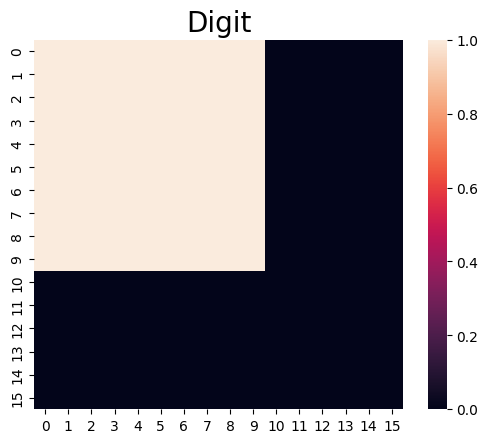

In [ ]:
f = plt.figure()
plt.title('Digit', fontsize=20)
sns.heatmap(dgt_cd,square=True)
plt.show()

In [ ]:
# Define function
def rdm_reord(org):
    new = org.copy()
    new[10:15,10:15] = org[11:,11:]
    new[15,15] = org[10,10]
    new[-1,10:15] = org[10,11:]
    new[10:15,-1] = org[11:,10]
    return new


il16 = np.tril_indices(16,-1)
def rsa(rdm_,code):
    rho, p = stats.spearmanr(code[il16],rdm_[il16])
    return rho, p

In [ ]:
# Load sample neural RDM made by '03_MVPA_Neural_RDMs.ipynb'
l = np.load('fMRI/Sample_Neural_RDM.npz', allow_pickle=True)
brain_rdm = l['rdm']
brain_inform_list = l['info_list']

# Number of searchlight voxels
nvv = brain_rdm.shape[0]

In [ ]:
# RSA
rsa_rslt = np.zeros((64,76,64))
rsa_rslt_pval = np.zeros((64,76,64))

for vi in range(nvv):
    idx = brain_inform_list[vi][1]
    rdm_ = rdm_reord(brain_rdm[vi])
    rsa_rslt[idx], rsa_rslt_pval[idx] = rsa(rdm_,dgt_cd)

In [ ]:
# ROI map associated with each concept
# In this tutorial, you would use rho values rather than t-statistics from group data.
p_threshold = 0.05
rsa_rslt[(rsa_rslt_pval > p_threshold)] = 0 # uncorrected p-values used in this sample code
rsa_rslt[(rsa_rslt < 0)] = 0 # Positive voxels

In [ ]:
# If you want to save ROI map obtained from sample data, you can run this cell.
# savedir = '/dir/to/save/' # Please set the path to save.

import nibabel as nib

affine = np.array([
    [   3. ,   -0. ,   -0. ,  -94.5],
    [  -0. ,    3. ,   -0. , -130.5],
    [   0. ,    0. ,    3. ,  -76.5],
    [   0. ,    0. ,    0. ,    1. ]
])

def save_nifti(vol, savepath, zero_to_nan=True):
    if zero_to_nan:
        vol[(vol==0)] = np.nan
    img1 = nib.Nifti1Image(vol,affine=affine)
    nib.save(img1,savepath)

save_nifti(rsa_rslt, 'fMRI/Digit.nii')